In [1]:
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt
import os

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')

print(device)

cuda


In [3]:
transform = transforms.Compose([
    transforms.Resize((28,28)),
    transforms.ToTensor()
])

train_dataset = datasets.MNIST('mnist',train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('mnist',train=False, transform=transform)
train_loader = DataLoader(train_dataset, num_workers=4,shuffle=True,batch_size=32)
test_loader = DataLoader(test_dataset, num_workers=4,shuffle=True,batch_size=32)

C:\ProgramData\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [19]:
class SoftMaxNet(nn.Module):
    def __init__(self):
        super(SoftMaxNet, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(1, 256, 5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(256, 256, 3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(256, 3, 5),
            nn.AdaptiveAvgPool2d(1))
        self.classifier = nn.Linear(3, 10)
        
    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(x.shape[0], 3)
        x = self.classifier(x)
        return x
    
    def get_feature(self, x):
        with torch.no_grad():
            x = self.conv_layer(x)
            x = x.view(x.shape[0], 3)
            x = F.normalize(x)
            return x

In [20]:
softmax_net = SoftMaxNet().to(device)
learning_rate = 0.1
criterion = nn.CrossEntropyLoss() # softmax 이미 포함
optimizer = optim.SGD(softmax_net.parameters(), lr=learning_rate)


In [22]:
def train(net,epoch):
    print('\n[ Train epoch: %d ]' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, prediction = outputs.max(1)

        total += labels.size(0)
        correct += prediction.eq(labels).sum().item()

        if batch_idx % 500 == 0:
            print('\nCurrent batch:', str(batch_idx))
            print('Current train accuracy:', str(prediction.eq(labels).sum().item() / labels.size(0)))
            print('Current train average loss:', loss.item() / 100)


    print('\nTrain accuarcy:', 100. * correct / total)
    print('Train average loss:', train_loss / total)


def test(net,epoch):
    print('\n[ Test epoch: %d ]' % epoch)
    net.eval()
    loss = 0
    correct = 0
    total = 0

    for batch_idx, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        total += labels.size(0)

        outputs = net(images)
        loss += criterion(outputs, labels).item()

        _, prediction = outputs.max(1)
        correct += prediction.eq(labels).sum().item()

    print('\nTest accuarcy:', 100. * correct / total)
    print('Test average loss:', loss / total)

In [23]:
for epoch in range(0,10) :
    train(softmax_net,epoch)


[ Train epoch: 0 ]

Current batch: 0
Current train accuracy: 0.40625
Current train average loss: 0.024019854068756105

Current batch: 500
Current train accuracy: 1.0
Current train average loss: 0.00041188135743141173

Current batch: 1000
Current train accuracy: 0.9375
Current train average loss: 0.0014691835641860963

Current batch: 1500
Current train accuracy: 0.9375
Current train average loss: 0.0019040465354919433

Train accuarcy: 95.115
Train average loss: 0.005272749417228624

[ Train epoch: 1 ]

Current batch: 0
Current train accuracy: 0.96875
Current train average loss: 0.0009576506912708282

Current batch: 500
Current train accuracy: 0.9375
Current train average loss: 0.0014711426198482514

Current batch: 1000
Current train accuracy: 0.90625
Current train average loss: 0.003066006004810333

Current batch: 1500
Current train accuracy: 0.96875
Current train average loss: 0.0006094751507043838

Train accuarcy: 97.54333333333334
Train average loss: 0.0026522019330625576

[ Train e

In [4]:
class ArcFaceNet(nn.Module):
    def __init__(self, classifier):
        super(self.__class__, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(1, 256, 5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(256, 256, 3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(256, 3, 5),
            nn.AdaptiveAvgPool2d(1)
        )
        self.classifier = classifier

    def forward(self, x):
        x = self.conv_layer(x)
        # 32,2,1,1
        x = x.view(x.shape[0], 3)
        # 32,2
        x = self.classifier(x)

        return x
    
    def get_feature(self, x):
        with torch.no_grad():
            x = self.conv_layer(x)
            x = x.view(x.shape[0], 3)
            x = F.normalize(x)
            return x

In [5]:
class ArcFaceClassifier(nn.Module):
    def __init__(self, emb_size, output_classes):
        super().__init__()
        self.W = nn.Parameter(torch.Tensor(emb_size, output_classes))
        nn.init.xavier_normal_(self.W)

    def forward(self, x):
        x_norm = F.normalize(x)
        W_norm = F.normalize(self.W, dim=0)


        # this output + margin will be logit's input
        return x_norm @ W_norm


In [6]:
# margin is added, then get loss
def arcface_loss(cosine,labels,m=0.4):
    cosine = cosine.clip(-1+1e-7, 1-1e-7) 
    # Step 1:
    arcosine = cosine.arccos()
    # Step 2:
    arcosine += F.one_hot(labels, 10) * m
    # Step 3:
    cosine2 = arcosine.cos()
    # Step 4:
    return F.cross_entropy(cosine2, labels)

In [7]:
def train(net,epoch):
    print('\n[ Train epoch: %d ]' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        cosine = net(images)
        loss = arcface_loss(cosine=cosine,labels=labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, prediction = cosine.max(1)

        total += labels.size(0)
        correct += prediction.eq(labels).sum().item()

        if batch_idx % 1000 == 0:
            print('\nCurrent batch:', str(batch_idx))
            print('Current train accuracy:', str(prediction.eq(labels).sum().item() / labels.size(0)))
            print('Current train average loss:', loss.item() / 100)


    print('\nTrain accuarcy:', 100. * correct / total)
    print('Train average loss:', train_loss / total)


def test(net,epoch):
    print('\n[ Test epoch: %d ]' % epoch)
    net.eval()
    loss = 0
    correct = 0
    total = 0

    for batch_idx, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        total += labels.size(0)

        outputs = net(images)
        loss += criterion(outputs, labels).item()

        _, prediction = outputs.max(1)
        correct += prediction.eq(labels).sum().item()

    print('\nTest accuarcy:', 100. * correct / total)
    print('Test average loss:', loss / total)

In [8]:

arcface_net = ArcFaceNet(ArcFaceClassifier(3,10)).to(device)

learning_rate = 0.1

optimizer = optim.SGD(arcface_net.parameters(), lr=learning_rate)


In [9]:
for epoch in range(0,20) :
    train(arcface_net,epoch)


[ Train epoch: 0 ]


C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)



Current batch: 0
Current train accuracy: 0.15625
Current train average loss: 0.026434445381164552

Current batch: 1000
Current train accuracy: 0.90625
Current train average loss: 0.01679643750190735

Train accuarcy: 85.49666666666667
Train average loss: 0.05310041148662567

[ Train epoch: 1 ]

Current batch: 0
Current train accuracy: 1.0
Current train average loss: 0.01583181619644165

Current batch: 1000
Current train accuracy: 0.96875
Current train average loss: 0.01560210347175598

Train accuarcy: 95.65833333333333
Train average loss: 0.05005012375911077

[ Train epoch: 2 ]

Current batch: 0
Current train accuracy: 1.0
Current train average loss: 0.01572150945663452

Current batch: 1000
Current train accuracy: 1.0
Current train average loss: 0.015778430700302125

Train accuarcy: 97.1
Train average loss: 0.04964916877945264

[ Train epoch: 3 ]

Current batch: 0
Current train accuracy: 0.9375
Current train average loss: 0.015893692970275878

Current batch: 1000
Current train accuracy

In [10]:
from tqdm.notebook import tqdm

def get_embs(model, dl):
    embs = []
    ys = []
    for bx,by in tqdm(dl):
        bx = bx.cuda()
        by = by.cuda()
        with torch.no_grad():
            embs.append(model.get_feature(bx))
            ys.append(by)
    embs = torch.cat(embs)
    embs = embs / embs.norm(p=2,dim=1)[:,None]
    ys = torch.cat(ys)
    return embs,ys

def plot_embs(embs, ys, ax):
    #ax.axis('off')
    for k in range(10):
        e = embs[ys==k].cpu()
        ax.scatter(e[:,0], e[:,1], e[:,2], s=4, alpha=.2)  

In [24]:
embs_arcface, ys_arcface  = get_embs(arcface_net, test_loader)
embs_softmax, ys_softmax  = get_embs(softmax_net, test_loader)

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

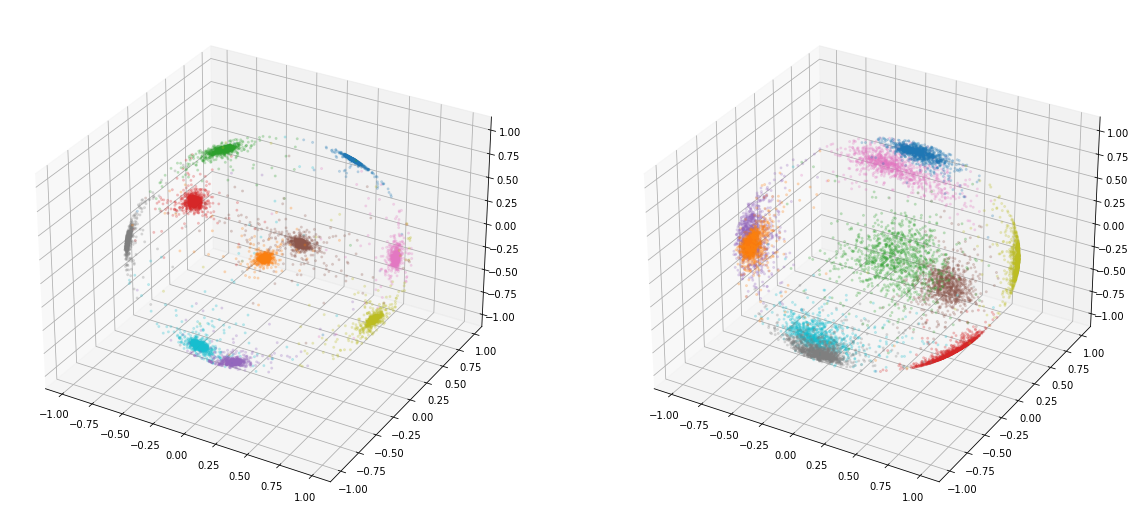

In [25]:
_,(ax1,ax2)=plt.subplots(1,2, figsize=(20,10), subplot_kw={'projection':'3d'})
plot_embs(embs_arcface, ys_arcface, ax1)
plot_embs(embs_softmax, ys_softmax, ax2)
plt.show()

ValueError: only one element tensors can be converted to Python scalars